# Khmer Next-Word Prediction — GRU (PyTorch)

This notebook trains a **Khmer next-word prediction** language model using **GRU** in PyTorch.

 Train my own **SentencePiece (BPE)** tokenizer on data full ~2.6GB corpus for maximum performance.

To **train only GRU now**. RNN/LSTM can be added later for compare from Team Member.

Pipeline:
1. Mount Drive + set paths
2. Normalize text (Khmer-only, remove English)
3. Build a clean corpus file (streaming)
4. Train SentencePiece tokenizer (BPE)
5. Train GRU language model (AMP, AdamW)
6. Evaluate (Perplexity + Top-k accuracy)
7. Inference demo (next-word suggestions)


## 0) Mount Google Drive (Colab)

Run this first in Colab.

In [1]:
# Colab only:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## 1) Paths + Config

Dataset files are located directly under:

`/content/drive/MyDrive/Khmer_Nextword_Prediction/`

Example:
- `kh_CC100.txt`
- `kh_oscar_Dataset.txt`

Artifacts will be written to:
- `Text Prediction/artifacts_final/`

In [3]:
from pathlib import Path
import os, random
import numpy as np
import torch

# =========================================================
# Project Paths (match your actual Drive structure)
# =========================================================
PROJECT_ROOT = Path("/content/drive/MyDrive/Khmer_Nextword_Prediction/Dataset")

# Your raw .txt files are DIRECTLY inside PROJECT_ROOT
DATA_DIR = PROJECT_ROOT

ARTIFACTS_DIR = PROJECT_ROOT / "artifacts_final"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

RAW_FILES = [
    DATA_DIR / "kh_CC100.txt",
    DATA_DIR / "kh_oscar_Dataset.txt",
]

# Fail fast
for p in RAW_FILES:
    if not p.exists():
        raise FileNotFoundError(
            f"Missing dataset file: {p}\n"
            f"Make sure it exists directly under: {DATA_DIR}"
        )
    print("Found:", p.resolve())

# Outputs
CLEAN_TXT = ARTIFACTS_DIR / "kh_clean_all.txt"

SPM_MODEL_PREFIX = ARTIFACTS_DIR / "spm_kh_bpe"
SPM_MODEL_PATH = SPM_MODEL_PREFIX.with_suffix(".model")
SPM_VOCAB_PATH = SPM_MODEL_PREFIX.with_suffix(".vocab")

# Split ratios (hash-based per-line)
SPLIT = {"train": 0.80, "val": 0.10, "test": 0.10}

# Tokenizer (Option B)
VOCAB_SIZE = int(os.getenv("VOCAB_SIZE", "32000"))
SPM_CHAR_COVERAGE = float(os.getenv("SPM_CHAR_COVERAGE", "0.9995"))

# LM (GRU)
SEQ_LEN    = int(os.getenv("SEQ_LEN", "256"))
BATCH_SIZE = int(os.getenv("BATCH_SIZE", "64"))

EMB_DIM  = int(os.getenv("EMB_DIM", "384"))
HID_DIM  = int(os.getenv("HID_DIM", "768"))
N_LAYERS = int(os.getenv("N_LAYERS", "2"))
DROPOUT  = float(os.getenv("DROPOUT", "0.2"))

# Training
EPOCHS      = int(os.getenv("EPOCHS", "10"))
LR          = float(os.getenv("LR", "0.001"))
WEIGHT_DECAY= float(os.getenv("WEIGHT_DECAY", "0.01"))
GRAD_CLIP   = float(os.getenv("GRAD_CLIP", "1.0"))

# Repro
SEED = int(os.getenv("SEED", "42"))
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("Artifacts:", ARTIFACTS_DIR.resolve())

Found: /content/drive/MyDrive/Khmer_Nextword_Prediction/Dataset/kh_CC100.txt
Found: /content/drive/MyDrive/Khmer_Nextword_Prediction/Dataset/kh_oscar_Dataset.txt
Device: cuda
Artifacts: /content/drive/MyDrive/Khmer_Nextword_Prediction/Dataset/artifacts_final


## 2) Khmer Normalization (Khmer-only, remove English)

We normalize Unicode (NFC), remove zero-width chars, convert Khmer digits to Arabic digits, normalize Khmer punctuation, and remove non-Khmer characters (including English words).

In [4]:
import re
import unicodedata

ZERO_WIDTH = {"\u200b", "\u200c", "\u200d", "\ufeff"}
KHMER_DIGITS = str.maketrans("០១២៣៤៥៦៧៨៩", "0123456789")

# Khmer-only allowed sets (no A-Za-z)
ALLOWED_RE = re.compile(
    r"[^0-9"
    r"\u1780-\u17FF"   # Khmer
    r"\u19E0-\u19FF"   # Khmer symbols
    r"\s"
    r"\.\,\!\?\:\;\-\(\)\"\'"
    r"\u2000-\u206F"   # General punctuation
    r"\u3000-\u303F"   # CJK punctuation
    r"\u00A0"
    r"\u2010-\u2015"
    r"\u2018-\u201F"
    r"\u2026"
    r"\u17D4\u17D5\u17D6\u17D7"  # Khmer punctuation
    r"]+"
)
MULTISPACE_RE = re.compile(r"\s+")

def normalize_khmer(text: str) -> str:
    text = unicodedata.normalize("NFC", text)
    for z in ZERO_WIDTH:
        text = text.replace(z, "")
    text = text.translate(KHMER_DIGITS)

    # Khmer punctuation normalization
    text = text.replace("\u17D4", ".")  # ។
    text = text.replace("\u17D5", ".")  # ៕
    text = text.replace("\u17D6", ":")  # ៖

    text = ALLOWED_RE.sub(" ", text)
    text = MULTISPACE_RE.sub(" ", text).strip()
    return text

# Quick tests
tests = [
    "ព្រះរាជាណាចក្រកម្ពុជា",
    "hello សួស្តី world",
    "GDP ឆ្នាំ២០២៤",
    "វិទ្យស្ថានបច្ចេកវិទ្យាកម្ពុជាជាឋានសួគ៍ក្រោមមេឃ!"
]
for t in tests:
    print("IN :", t)
    print("OUT:", normalize_khmer(t))
    print("-"*40)

IN : ព្រះរាជាណាចក្រកម្ពុជា
OUT: ព្រះរាជាណាចក្រកម្ពុជា
----------------------------------------
IN : hello សួស្តី world
OUT: សួស្តី
----------------------------------------
IN : GDP ឆ្នាំ២០២៤
OUT: ឆ្នាំ2024
----------------------------------------
IN : វិទ្យស្ថានបច្ចេកវិទ្យាកម្ពុជាជាឋានសួគ៍ក្រោមមេឃ!
OUT: វិទ្យស្ថានបច្ចេកវិទ្យាកម្ពុជាជាឋានសួគ៍ក្រោមមេឃ!
----------------------------------------


## 3) Build Clean Corpus (Streaming)

This creates `kh_clean_all.txt` inside `artifacts_final/`.

It streams through your 2.6GB text, so it won't blow RAM.

> Run this once. If the file already exists, you can skip.

In [5]:
from tqdm import tqdm

def iter_lines(paths):
    for path in paths:
        with path.open("r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                yield line

def build_clean_corpus(out_path: Path, paths, min_len=1):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    kept, dropped = 0, 0
    with out_path.open("w", encoding="utf-8") as w:
        for line in tqdm(iter_lines(paths), desc="Normalizing (stream)"):
            s = normalize_khmer(line)
            if len(s) >= min_len:
                w.write(s + "\n")
                kept += 1
            else:
                dropped += 1
    print(f"Done. kept={kept:,} dropped={dropped:,} -> {out_path}")

# Run if missing
if not CLEAN_TXT.exists():
    build_clean_corpus(CLEAN_TXT, RAW_FILES, min_len=1)
else:
    print("Clean corpus already exists:", CLEAN_TXT)

Normalizing (stream): 3159840it [04:07, 12756.89it/s]

Done. kept=3,159,840 dropped=0 -> /content/drive/MyDrive/Khmer_Nextword_Prediction/Dataset/artifacts_final/kh_clean_all.txt


## 4) Train SentencePiece from our own dataset

This trains a **BPE tokenizer** on clean corpus.

It will create:
- `spm_kh_bpe.model`
- `spm_kh_bpe.vocab`

> Let's see how it works.

In [6]:
!pip -q install sentencepiece
import sentencepiece as spm

def train_sentencepiece(input_txt: Path, model_prefix: Path, vocab_size=32000, character_coverage=0.9995):
    spm.SentencePieceTrainer.Train(
        input=str(input_txt),
        model_prefix=str(model_prefix),
        vocab_size=int(vocab_size),
        model_type="bpe",
        character_coverage=float(character_coverage),
        pad_id=0,
        bos_id=1,
        eos_id=2,
        unk_id=3,
        input_sentence_size=2000000,
        shuffle_input_sentence=True
    )
    print("Saved:", model_prefix.with_suffix(".model"))
    print("Saved:", model_prefix.with_suffix(".vocab"))

# Train tokenizer if missing
if not SPM_MODEL_PATH.exists():
    train_sentencepiece(CLEAN_TXT, SPM_MODEL_PREFIX, vocab_size=VOCAB_SIZE, character_coverage=SPM_CHAR_COVERAGE)
else:
    print("SentencePiece model exists:", SPM_MODEL_PATH)

print("Exists model:", SPM_MODEL_PATH.exists())
print("Exists vocab:", SPM_VOCAB_PATH.exists())

Saved: /content/drive/MyDrive/Khmer_Nextword_Prediction/Dataset/artifacts_final/spm_kh_bpe.model
Saved: /content/drive/MyDrive/Khmer_Nextword_Prediction/Dataset/artifacts_final/spm_kh_bpe.vocab
Exists model: True
Exists vocab: True


## 5) Load Tokenizer + Quick Inspection

In [22]:
import sentencepiece as spm

sp = spm.SentencePieceProcessor()
sp.load(str(SPM_MODEL_PATH))

print("Vocab size:", sp.get_piece_size())
print("pad:", sp.pad_id(), "bos:", sp.bos_id(), "eos:", sp.eos_id(), "unk:", sp.unk_id())

txt = "ប្រទេសកម្ពុជាជាផ្ទះរបស់ខ្ញុំ"
norm = normalize_khmer(txt)
ids = sp.encode(norm, out_type=int)
pieces = sp.encode(norm, out_type=str)

print("Text:", txt)
print("Norm:", norm)
print("Pieces:", pieces[:50])
print("Decoded:", sp.decode(ids))

Vocab size: 32000
pad: 0 bos: 1 eos: 2 unk: 3
Text: ប្រទេសកម្ពុជាជាផ្ទះរបស់ខ្ញុំ
Norm: ប្រទេសកម្ពុជាជាផ្ទះរបស់ខ្ញុំ
Pieces: ['▁ប្រទេសកម្ពុជា', 'ជា', 'ផ្ទះ', 'របស់ខ្ញុំ']
Decoded: ប្រទេសកម្ពុជាជាផ្ទះរបស់ខ្ញុំ


## 6) Streaming Split + Token Chunking

We split by hashing each line (deterministic). Then we add BOS/EOS and chunk into fixed-length sequences for next-token prediction.

In [8]:
import hashlib
from typing import Iterator, List, Tuple

def split_of_line(line: str, split=SPLIT) -> str:
    h = hashlib.md5(line.encode("utf-8", errors="ignore")).hexdigest()
    x = int(h[:8], 16) / 0xFFFFFFFF
    if x < split["train"]:
        return "train"
    elif x < split["train"] + split["val"]:
        return "val"
    else:
        return "test"

def iter_split_lines(clean_path: Path, which: str) -> Iterator[str]:
    with clean_path.open("r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            if split_of_line(s) == which:
                yield s

def chunk_tokens(token_ids: List[int], seq_len: int) -> Iterator[Tuple[List[int], List[int]]]:
    if len(token_ids) < 2:
        return
    for i in range(0, len(token_ids) - 1, seq_len):
        block = token_ids[i:i + seq_len + 1]
        if len(block) < 2:
            continue
        yield block[:-1], block[1:]

## 7) PyTorch Dataset/DataLoader (Iterable)

This streams token blocks so training is feasible on multi-GB corpora.

In [9]:
import torch
from torch.utils.data import IterableDataset, DataLoader

class StreamLMDataset(IterableDataset):
    def __init__(self, clean_path: Path, sp, split_name: str, seq_len: int):
        super().__init__()
        self.clean_path = clean_path
        self.sp = sp
        self.split_name = split_name
        self.seq_len = seq_len

    def __iter__(self):
        for line in iter_split_lines(self.clean_path, self.split_name):
            ids = [self.sp.bos_id()] + self.sp.encode(line, out_type=int) + [self.sp.eos_id()]
            for x, y in chunk_tokens(ids, self.seq_len):
                yield torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

def collate_pad(batch):
    pad_id = sp.pad_id()
    xs, ys = zip(*batch)
    max_len = max(x.size(0) for x in xs)
    x_pad = torch.full((len(xs), max_len), pad_id, dtype=torch.long)
    y_pad = torch.full((len(ys), max_len), pad_id, dtype=torch.long)
    for i, (x, y) in enumerate(zip(xs, ys)):
        x_pad[i, :x.size(0)] = x
        y_pad[i, :y.size(0)] = y
    return x_pad, y_pad

train_ds = StreamLMDataset(CLEAN_TXT, sp, "train", seq_len=SEQ_LEN)
val_ds   = StreamLMDataset(CLEAN_TXT, sp, "val",   seq_len=SEQ_LEN)
test_ds  = StreamLMDataset(CLEAN_TXT, sp, "test",  seq_len=SEQ_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_pad, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, collate_fn=collate_pad, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, collate_fn=collate_pad, num_workers=0)

print("Loaders ready.")

Loaders ready.


## 8) GRU Language Model (PyTorch)

We train **only GRU** now. RNN/LSTM can be added later.

In [10]:
import torch.nn as nn

class GRULanguageModel(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int, hid_dim: int, n_layers: int, dropout: float, pad_id: int):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_id)
        self.drop = nn.Dropout(dropout)
        self.gru = nn.GRU(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0.0,
            batch_first=True
        )
        self.fc = nn.Linear(hid_dim, vocab_size)

    def forward(self, x, hidden=None):
        emb = self.drop(self.emb(x))
        out, hidden = self.gru(emb, hidden)
        out = self.drop(out)
        logits = self.fc(out)
        return logits, hidden

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## 9) Training + Evaluation (Perplexity + Top-k)

We use AMP for speed and gradient clipping for stability.

We log:
- train loss
- validation loss + perplexity
- top-1 / top-3 accuracy
- tokens/sec
- peak GPU memory (GB)

In [12]:
import math, time
from dataclasses import dataclass
from tqdm import tqdm
import torch.nn.functional as F

@dataclass
class Metrics:
    loss: float
    ppl: float
    top1: float
    top3: float

def batch_metrics(logits, targets, pad_id: int, k3=3):
    B, T, V = logits.shape
    logits2 = logits.reshape(B*T, V)
    targets2 = targets.reshape(B*T)
    mask = targets2 != pad_id
    if mask.sum().item() == 0:
        return 0.0, 0.0, 0
    logits_m = logits2[mask]
    targets_m = targets2[mask]
    top1 = (logits_m.argmax(dim=-1) == targets_m).float().mean().item()
    topk3 = logits_m.topk(k=min(k3, V), dim=-1).indices
    top3 = (topk3 == targets_m.unsqueeze(-1)).any(dim=-1).float().mean().item()
    return top1, top3, int(mask.sum().item())

def evaluate(model, loader, device, pad_id):
    model.eval()
    loss_fn = nn.CrossEntropyLoss(ignore_index=pad_id, reduction="sum")
    total_loss, total_tokens = 0.0, 0
    total_top1, total_top3 = 0.0, 0.0
    with torch.no_grad():
        for x, y in tqdm(loader, desc="Eval", leave=False):
            x, y = x.to(device), y.to(device)
            logits, _ = model(x)
            B, T, V = logits.shape
            loss = loss_fn(logits.view(B*T, V), y.view(B*T))
            total_loss += loss.item()
            top1, top3, n = batch_metrics(logits, y, pad_id)
            total_top1 += top1 * n
            total_top3 += top3 * n
            total_tokens += n

    avg_loss = total_loss / max(total_tokens, 1)
    ppl = math.exp(min(avg_loss, 50))
    return Metrics(avg_loss, ppl, total_top1/max(total_tokens,1), total_top3/max(total_tokens,1))

def train_gru(train_loader, val_loader, device):
    vocab_size = sp.get_piece_size()
    pad_id = sp.pad_id()

    model = GRULanguageModel(
        vocab_size=vocab_size,
        emb_dim=EMB_DIM,
        hid_dim=HID_DIM,
        n_layers=N_LAYERS,
        dropout=DROPOUT,
        pad_id=pad_id
    ).to(device)

    print("GRU params:", count_params(model))

    loss_fn = nn.CrossEntropyLoss(ignore_index=pad_id, reduction="mean")
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=1)

    history = {"train_loss": [], "val_loss": [], "val_ppl": [], "val_top1": [], "val_top3": [],
               "epoch_time_sec": [], "tokens_per_sec": [], "gpu_peak_gb": []}

    best_val = float("inf")
    best_path = ARTIFACTS_DIR / "best_gru.pt"

    for ep in range(1, EPOCHS+1):
        model.train()
        running, steps = 0.0, 0
        epoch_start = time.time()
        if device.type=="cuda":
            torch.cuda.reset_peak_memory_stats()

        for x, y in tqdm(train_loader, desc=f"Train GRU ep{ep}", leave=False):
            x, y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
                logits, _ = model(x)
                B, T, V = logits.shape
                loss = loss_fn(logits.view(B*T, V), y.view(B*T))

            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            scaler.step(opt)
            scaler.update()

            running += loss.item()
            steps += 1

        epoch_time = time.time() - epoch_start
        avg_train = running / max(steps, 1)

        # tokens/sec estimate
        tokens = steps * BATCH_SIZE * SEQ_LEN
        tps = tokens / max(epoch_time, 1e-6)

        peak_gb = None
        if device.type=="cuda":
            peak_gb = torch.cuda.max_memory_allocated() / 1024**3

        val = evaluate(model, val_loader, device, pad_id)

        history["train_loss"].append(avg_train)
        history["val_loss"].append(val.loss)
        history["val_ppl"].append(val.ppl)
        history["val_top1"].append(val.top1)
        history["val_top3"].append(val.top3)
        history["epoch_time_sec"].append(epoch_time)
        history["tokens_per_sec"].append(tps)
        history["gpu_peak_gb"].append(peak_gb)

        print(
            f"Epoch {ep}/{EPOCHS} | train_loss={avg_train:.4f} | "
            f"val_loss={val.loss:.4f} | val_ppl={val.ppl:.2f} | "
            f"top1={val.top1:.3f} | top3={val.top3:.3f} | "
            f"time={epoch_time/60:.1f}m | tps\u2248{tps:,.0f} | peakGB={peak_gb}"
        )

        scheduler.step(val.loss)

        if val.loss < best_val:
            best_val = val.loss
            torch.save(
                {"model": model.state_dict(),
                 "config": {"vocab_size": vocab_size, "emb_dim": EMB_DIM, "hid_dim": HID_DIM,
                            "n_layers": N_LAYERS, "dropout": DROPOUT}},
                best_path
            )
            print("Saved best:", best_path)

    return model, history, best_path

gru_model, history, best_path = train_gru(train_loader, val_loader, device)


/tmp/ipython-input-3407622992.py:66: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


GRU params: 43098368


Train GRU ep1: 0it [00:00, ?it/s]/tmp/ipython-input-3407622992.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 1/10 | train_loss=6.5181 | val_loss=4.9806 | val_ppl=145.57 | top1=0.273 | top3=0.350 | time=25.7m | tps≈464,757 | peakGB=6.96476936340332
Saved best: /content/drive/MyDrive/Khmer_Nextword_Prediction/Dataset/artifacts_final/best_gru.pt


Epoch 2/10 | train_loss=5.9656 | val_loss=4.7421 | val_ppl=114.67 | top1=0.291 | top3=0.373 | time=25.1m | tps≈476,047 | peakGB=6.96574592590332
Saved best: /content/drive/MyDrive/Khmer_Nextword_Prediction/Dataset/artifacts_final/best_gru.pt


Epoch 3/10 | train_loss=5.7407 | val_loss=4.5629 | val_ppl=95.86 | top1=0.307 | top3=0.392 | time=25.3m | tps≈471,892 | peakGB=6.96574592590332
Saved best: /content/drive/MyDrive/Khmer_Nextword_Prediction/Dataset/artifacts_final/best_gru.pt


Epoch 4/10 | train_loss=5.6058 | val_loss=4.4497 | val_ppl=85.60 | top1=0.317 | top3=0.404 | time=25.1m | tps≈476,498 | peakGB=6.96574592590332
Saved best: /content/drive/MyDrive/Khmer_Nextword_Prediction/Dataset/artifacts_final/best_gru.pt


Epoch 5/10 | train_loss=5.5344 | val_loss=4.3889 | val_ppl=80.55 | top1=0.323 | top3=0.410 | time=25.0m | tps≈477,060 | peakGB=6.96574592590332
Saved best: /content/drive/MyDrive/Khmer_Nextword_Prediction/Dataset/artifacts_final/best_gru.pt


Train GRU ep6: 37631it [14:23, 47.48it/s]/tmp/ipython-input-3407622992.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


KeyboardInterrupt: 

## 10) Test Evaluation (Best GRU Checkpoint)

In [14]:
from pathlib import Path

BEST_GRU_PATH = Path(
    "/content/drive/MyDrive/Khmer_Nextword_Prediction/Dataset/artifacts_final/best_gru.pt"
)
def load_best_gru(path: Path, device):
    ckpt = torch.load(path, map_location=device)
    cfg = ckpt["config"]
    model = GRULanguageModel(
        vocab_size=cfg["vocab_size"],
        emb_dim=cfg["emb_dim"],
        hid_dim=cfg["hid_dim"],
        n_layers=cfg["n_layers"],
        dropout=cfg["dropout"],
        pad_id=sp.pad_id()
    ).to(device)
    model.load_state_dict(ckpt["model"])
    model.eval()
    return model
best_gru = load_best_gru(BEST_GRU_PATH, device)
test_metrics = evaluate(best_gru, test_loader, device, sp.pad_id())
print("TEST:", test_metrics)


TEST: Metrics(loss=4.404855499824766, ppl=81.84731503726286, top1=0.32072023667717114, top3=0.4085524394948823)


## 11) Plots (Loss / Perplexity / Speed / GPU Memory)

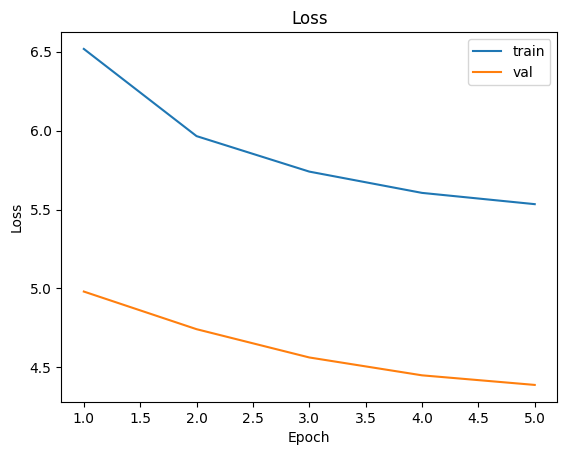

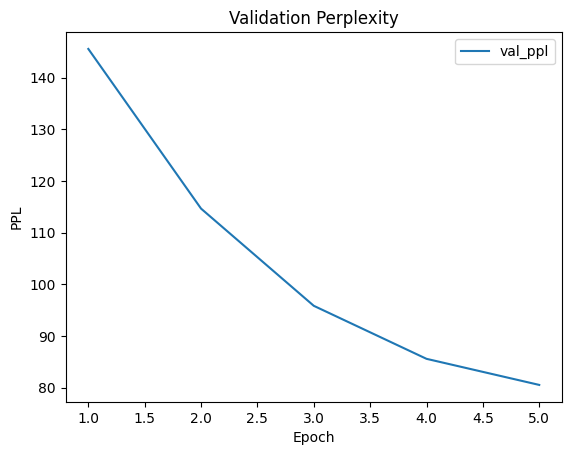

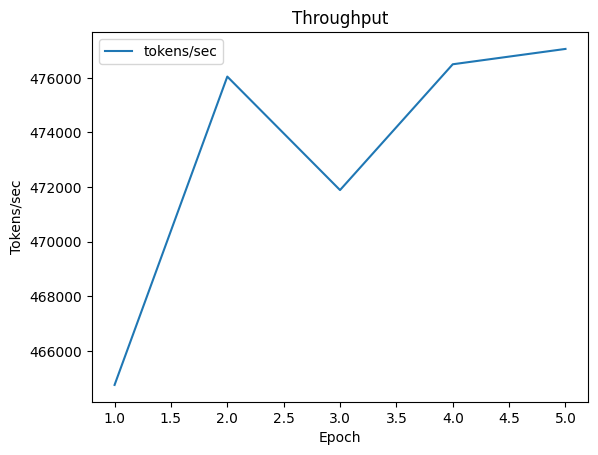

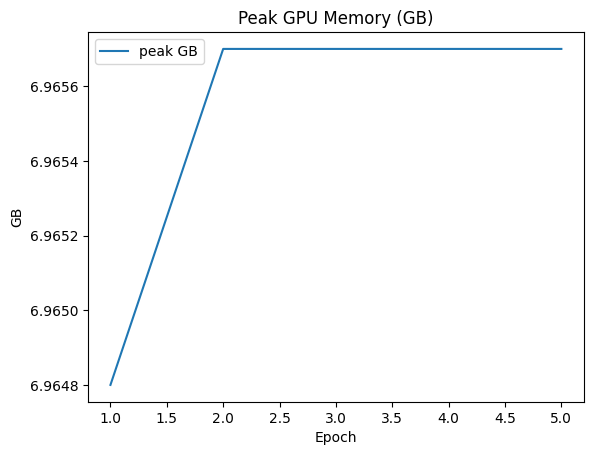

In [16]:
history = {
    "train_loss": [
        6.5181,
        5.9656,
        5.7407,
        5.6058,
        5.5344,
    ],
    "val_loss": [
        4.9806,
        4.7421,
        4.5629,
        4.4497,
        4.3889,
    ],
    "val_ppl": [
        145.57,
        114.67,
        95.86,
        85.60,
        80.55,
    ],
    "top1": [
        0.273,
        0.291,
        0.307,
        0.317,
        0.323,
    ],
    "top3": [
        0.350,
        0.373,
        0.392,
        0.404,
        0.410,
    ],
    "tokens_per_sec": [
        464_757,
        476_047,
        471_892,
        476_498,
        477_060,
    ],
    "gpu_peak_gb": [
        6.9648,
        6.9657,
        6.9657,
        6.9657,
        6.9657,
    ],
}

import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="train")
plt.plot(epochs, history["val_loss"], label="val")
plt.title("Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

plt.figure()
plt.plot(epochs, history["val_ppl"], label="val_ppl")
plt.title("Validation Perplexity")
plt.xlabel("Epoch"); plt.ylabel("PPL"); plt.legend(); plt.show()

plt.figure()
plt.plot(epochs, history["tokens_per_sec"], label="tokens/sec")
plt.title("Throughput")
plt.xlabel("Epoch"); plt.ylabel("Tokens/sec"); plt.legend(); plt.show()

plt.figure()
plt.plot(epochs, history["gpu_peak_gb"], label="peak GB")
plt.title("Peak GPU Memory (GB)")
plt.xlabel("Epoch"); plt.ylabel("GB"); plt.legend(); plt.show()


## 12) Inference: Next-Word Suggestions (Top-k)

We predict the next token distribution and show the top candidates.

Note: SentencePiece uses subwords; decoded tokens may be partial pieces — that's normal.

In [17]:
def suggest_next(model, text: str, topk: int = 10, temperature: float = 1.0):
    model.eval()
    s = normalize_khmer(text)
    ids = [sp.bos_id()] + sp.encode(s, out_type=int)
    x = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        logits, _ = model(x)
        last = logits[0, -1] / max(temperature, 1e-6)
        probs = torch.softmax(last, dim=-1)
        top = torch.topk(probs, k=topk)
        out = []
        for pid, p in zip(top.indices.tolist(), top.values.tolist()):
            out.append((pid, sp.id_to_piece(pid), sp.decode([pid]), float(p)))
    return s, out

prompt = "ខ្ញុំស្រលាញ់"
norm_prompt, suggestions = suggest_next(best_gru, prompt, topk=10, temperature=1.0)
print("Prompt:", norm_prompt)
for pid, piece, decoded, p in suggestions:
    print(f"{p:.4f} | id={pid:5d} | piece={piece} | decoded='{decoded}'")

Prompt: ខ្ញុំស្រលាញ់
0.1132 | id=  108 | piece=អ្នក | decoded='អ្នក'
0.0291 | id=  624 | piece=កូន | decoded='កូន'
0.0190 | id=  145 | piece=ក្រុម | decoded='ក្រុម'
0.0141 | id=   11 | piece=ការ | decoded='ការ'
0.0125 | id= 1318 | piece=សត្វ | decoded='សត្វ'
0.0091 | id=   68 | piece=លោក | decoded='លោក'
0.0090 | id=  210 | piece=ព្រះ | decoded='ព្រះ'
0.0085 | id=10262 | piece=ព្រះជាម្ចាស់ | decoded='ព្រះជាម្ចាស់'
0.0083 | id=  386 | piece=ស្រី | decoded='ស្រី'
0.0067 | id=  786 | piece=នាង | decoded='នាង'


In [23]:
demo_prompts = [
    "ខ្ញុំស្រលាញ់",
    "ប្រទេសកម្ពុជា",
    "សិស្សនិស្សិត",
    "នៅក្នុងជីវិត",
    "បច្ចេកវិទ្យា",
    "ការសិក្សា",
]

for prompt in demo_prompts:
    norm_prompt, suggestions = suggest_next(
        best_gru, prompt, topk=8, temperature=1.0
    )
    print("=" * 60)
    print("Prompt:", norm_prompt)
    for pid, piece, decoded, p in suggestions:
        print(f"{p:.4f} | {decoded}")


Prompt: ខ្ញុំស្រលាញ់
0.1132 | អ្នក
0.0291 | កូន
0.0190 | ក្រុម
0.0141 | ការ
0.0125 | សត្វ
0.0091 | លោក
0.0090 | ព្រះ
0.0085 | ព្រះជាម្ចាស់
Prompt: ប្រទេសកម្ពុជា
0.0420 | គឺជាប្រទេស
0.0403 | មាន
0.0318 | :
0.0265 | កំពុង
0.0229 | ជាប្រទេស
0.0200 | ត្រូវបាន
0.0189 | ជាប្រទេស
0.0169 | និង
Prompt: សិស្សនិស្សិត
0.0371 | ចំនួន
0.0228 | អាហារូបករណ៍
0.0216 | មកពី
0.0186 | នៃវិទ្យាស្ថាន
0.0183 | កម្ពុជា
0.0176 | នៃសាកលវិទ្យាល័យ
0.0164 | ជ័យលាភី
0.0141 | ឆ្នាំទី
Prompt: នៅក្នុងជីវិត
0.0402 | របស់ខ្ញុំ
0.0359 | របស់
0.0325 | ប្រចាំថ្ងៃ
0.0276 | របស់គាត់
0.0251 | របស់លោក
0.0249 | របស់មនុស្ស
0.0205 | របស់យើង
0.0164 | របស់ខ្លួន
Prompt: បច្ចេកវិទ្យា
0.0454 | :
0.0412 | :
0.0379 | និង
0.0218 | ថ្មី
0.0099 | ពិតជា
0.0088 | ឌីជីថល
0.0083 | ក្រុមហ៊ុន
0.0077 | លោក
Prompt: ការសិក្សា
0.1415 | ថ្មីមួយ
0.0826 | បានបង្ហាញថា
0.0819 | ថ្មី
0.0508 | ថ្មីមួយបាន
0.0435 | :
0.0334 | អំពី
0.0313 | ពី
0.0148 | ថ្មីៗ


In [24]:
prompt = "ខ្ញុំស្រលាញ់"

for T in [0.7, 1.0, 1.3]:
    norm_prompt, suggestions = suggest_next(
        best_gru, prompt, topk=8, temperature=T
    )
    print("\n" + "=" * 60)
    print(f"Prompt: {norm_prompt} | temperature={T}")
    for pid, piece, decoded, p in suggestions:
        print(f"{p:.4f} | {decoded}")



Prompt: ខ្ញុំស្រលាញ់ | temperature=0.7
0.4596 | អ្នក
0.0660 | កូន
0.0359 | ក្រុម
0.0235 | ការ
0.0197 | សត្វ
0.0125 | លោក
0.0123 | ព្រះ
0.0114 | ព្រះជាម្ចាស់

Prompt: ខ្ញុំស្រលាញ់ | temperature=1.0
0.1132 | អ្នក
0.0291 | កូន
0.0190 | ក្រុម
0.0141 | ការ
0.0125 | សត្វ
0.0091 | លោក
0.0090 | ព្រះ
0.0085 | ព្រះជាម្ចាស់

Prompt: ខ្ញុំស្រលាញ់ | temperature=1.3
0.0305 | អ្នក
0.0107 | កូន
0.0077 | ក្រុម
0.0062 | ការ
0.0056 | សត្វ
0.0044 | លោក
0.0043 | ព្រះ
0.0042 | ព្រះជាម្ចាស់


In [25]:
def generate_text(
    model,
    prompt: str,
    max_new_tokens: int = 20,
    temperature: float = 1.0,
    topk: int = 20,
):
    model.eval()
    s = normalize_khmer(prompt)
    ids = [sp.bos_id()] + sp.encode(s, out_type=int)

    x = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(max_new_tokens):
            logits, _ = model(x)
            last = logits[0, -1] / max(temperature, 1e-6)
            probs = torch.softmax(last, dim=-1)

            top = torch.topk(probs, k=topk)
            pid = top.indices[
                torch.multinomial(top.values, 1)
            ].item()

            x = torch.cat(
                [x, torch.tensor([[pid]], device=device)],
                dim=1
            )

    return sp.decode(x[0].tolist())


In [26]:
prompts = [
    "ខ្ញុំស្រលាញ់",
    "ប្រទេសកម្ពុជា",
    "ការសិក្សា និង",
]

for p in prompts:
    print("\n" + "=" * 60)
    print("Prompt:", p)
    print("Generated:")
    print(generate_text(best_gru, p, max_new_tokens=25, temperature=1.0))



Prompt: ខ្ញុំស្រលាញ់
Generated:
ខ្ញុំស្រលាញ់អ្នកបំផុត .អ្នកលេងល្បែងដែលចូលចិត្តរាំនិងកំប្លែង. អ្នកលេងជាច្រើនចូលចិត្តលេងល្បែងអនឡាញ. ការលេងល្បែងនេះធ្វើឱ្យខ្ញុំមានការព្រួយបារម្ភអំពី

Prompt: ប្រទេសកម្ពុជា
Generated:
ប្រទេសកម្ពុជាគឺជាប្រទេសមួយដែលមានផ្ទៃដីចំនួន101 ⁇ ហិចតា មានផ្ទៃដីសរុប ⁇ 3ហិចតា និងផ្ទៃដីសរុបចំនួន3 ⁇ ហិចតា មានផ្ទៃដីដាំដុះសរុបចំនួន1

Prompt: ការសិក្សា និង
Generated:
ការសិក្សា និងអនុសាសន៍សំខាន់ៗ ដែលរាជរដ្ឋាភិបាលបានចាត់ទុក និងកំណើនរបស់សហរដ្ឋអាមេរិកសម្រាប់អាណត្តិទី ⁇  ក្រោមការដឹកនាំរបស់សម្តេចតេជោ ហ៊ុន សែន នាយករដ្ឋមន្ត្រីនៃព្រះរាជាណាចក្រកម្ពុជា ដែលបានដាក់ចេញគោលនយោបាយអភិវឌ្ឍន៍វិស័យឧស្សាហកម្ម
